In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

In [2]:
train_df = pd.read_csv('data/cleaned_data.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder
cat_features = ['neighbourhood_cleansed', 'property_type', 'room_type']
num_features = ['bedrooms', 'beds', 'baths', 'accommodates',
                    'review_scores_rating', 'review_scores_accuracy',
                    'review_scores_cleanliness', 'review_scores_checkin',
                    'review_scores_communication', 'review_scores_location',
                    'review_scores_value', 'reviews_per_month']

label_encoder = LabelEncoder()

for cat_col in cat_features: 
    train_df[cat_col] = label_encoder.fit_transform(train_df[cat_col])


In [4]:
y = train_df['monthly_revenue']
X = train_df[cat_features + num_features]

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import optuna

# Objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    
    # 10-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    rmse_list, mae_list, r2_list, adjusted_r2_list = [], [], [], []
    n_features = X.shape[1]  # Number of features
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Convert data to DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # Train the model
        model = xgb.train(param, dtrain, num_boost_round=500, evals=[(dtest, 'eval')],
                          early_stopping_rounds=50, verbose_eval=False)
        
        # Predict and calculate metrics
        preds = model.predict(dtest)
        
        # RMSE
        rmse = mean_squared_error(y_test, preds, squared=False)
        rmse_list.append(rmse)
        
        # MAE
        mae = mean_absolute_error(y_test, preds)
        mae_list.append(mae)
        
        # R²
        r2 = r2_score(y_test, preds)
        r2_list.append(r2)
        
        # Adjusted R²
        n_samples = len(y_test)
        adjusted_r2 = 1 - ((1 - r2) * (n_samples - 1) / (n_samples - n_features - 1))
        adjusted_r2_list.append(adjusted_r2)
    
    # Report the mean RMSE as the optimization metric
    return np.mean(rmse_list)

# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=50)

# Print best parameters and RMSE
print("Best Parameters:", study.best_params)
print("Best RMSE from 10-Fold CV:", study.best_value)

# Evaluate final metrics on 10-Fold CV using best parameters
def evaluate_final_model(best_params):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    rmse_list, mae_list, r2_list, adjusted_r2_list = [], [], [], []
    n_features = X.shape[1]
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Convert data to DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # Train the model
        model = xgb.train(best_params, dtrain, num_boost_round=500, evals=[(dtest, 'eval')],
                          early_stopping_rounds=50, verbose_eval=False)
        
        # Predict and calculate metrics
        preds = model.predict(dtest)
        
        # RMSE
        rmse = mean_squared_error(y_test, preds, squared=False)
        rmse_list.append(rmse)
        
        # MAE
        mae = mean_absolute_error(y_test, preds)
        mae_list.append(mae)
        
        # R²
        r2 = r2_score(y_test, preds)
        r2_list.append(r2)
        
        # Adjusted R²
        n_samples = len(y_test)
        adjusted_r2 = 1 - ((1 - r2) * (n_samples - 1) / (n_samples - n_features - 1))
        adjusted_r2_list.append(adjusted_r2)
    
    # Print average metrics across all folds
    print(f"Mean RMSE: {np.mean(rmse_list):.4f}")
    print(f"Mean MAE: {np.mean(mae_list):.4f}")
    print(f"Mean R²: {np.mean(r2_list):.4f}")
    print(f"Mean Adjusted R²: {np.mean(adjusted_r2_list):.4f}")
    
    return np.mean(rmse_list), np.mean(mae_list), np.mean(r2_list), np.mean(adjusted_r2_list), model

# Use the best parameters to evaluate final model
final_params = study.best_params
final_params['objective'] = 'reg:squarederror'
final_params['eval_metric'] = 'rmse'

mean_rmse, mean_mae, mean_r2, mean_r2_adjusted, model = evaluate_final_model(final_params)


[I 2024-11-27 21:18:14,747] A new study created in memory with name: no-name-1de1b1e0-1605-47b9-b292-5da20e23a018
/Users/harrypotter/Documents/Comps/WiDSCase/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/harrypotter/Documents/Comps/WiDSCase/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/harrypotter/Documents/Comps/WiDSCase/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.w

Best Parameters: {'max_depth': 3, 'learning_rate': 0.024700553321727187, 'subsample': 0.7171783397409788, 'colsample_bytree': 0.5962875717616708, 'reg_alpha': 0.41965311409317974, 'reg_lambda': 0.7360404498863653}
Best RMSE from 10-Fold CV: 1120.8251877061298


/Users/harrypotter/Documents/Comps/WiDSCase/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/harrypotter/Documents/Comps/WiDSCase/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/harrypotter/Documents/Comps/WiDSCase/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/harrypotter/Documents/Comps/WiDSCase/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:4

Mean RMSE: 1120.8252
Mean MAE: 911.9637
Mean R²: 0.2907
Mean Adjusted R²: 0.2702


In [13]:




results_df = pd.read_csv('results.csv')

xgb_res = pd.DataFrame({
    "Model": 'XGBoost',
    "RMSE": [mean_rmse],
    "MAE": [mean_mae],
    "R²": [mean_r2],
    "R² Adjusted": [mean_r2_adjusted]
})
results_df = pd.concat([results_df, xgb_res], ignore_index=True)
results_df = results_df.sort_values(by='RMSE', ascending=False)
print(results_df)

     Model         RMSE         MAE        R²  R² Adjusted
0       LR  1163.750197  943.460734  0.235424     0.213335
1       RF  1121.375410  916.135361  0.268202     0.259972
3  XGBoost  1120.825188  911.963707  0.290663     0.270170
2      FNN  1119.353149  908.828308  0.292400     0.164088


In [16]:
results_df.to_csv('results.csv', index=False)

In [33]:
print("Best Hyperparameters from Optuna:")
print(f"max_depth: {final_params['max_depth']}")
print(f"learning_rate: {final_params['learning_rate']}")
print(f"subsample: {final_params['subsample']}")
print(f"colsample_bytree: {final_params['colsample_bytree']}")
print(f"reg_alpha: {final_params['reg_alpha']}")
print(f"reg_lambda: {final_params['reg_lambda']}")



Best Hyperparameters from Optuna:
max_depth: 3
learning_rate: 0.024700553321727187
subsample: 0.7171783397409788
colsample_bytree: 0.5962875717616708
reg_alpha: 0.41965311409317974
reg_lambda: 0.7360404498863653


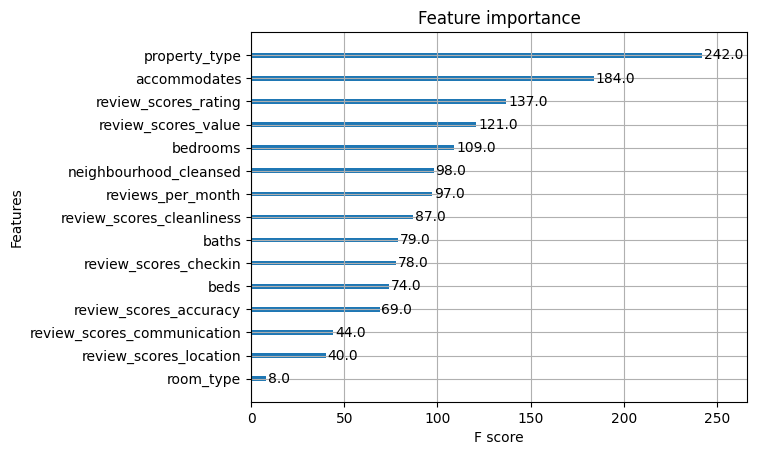

In [19]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, importance_type='weight')  # Replace 'final_model' with your model variable
plt.show()

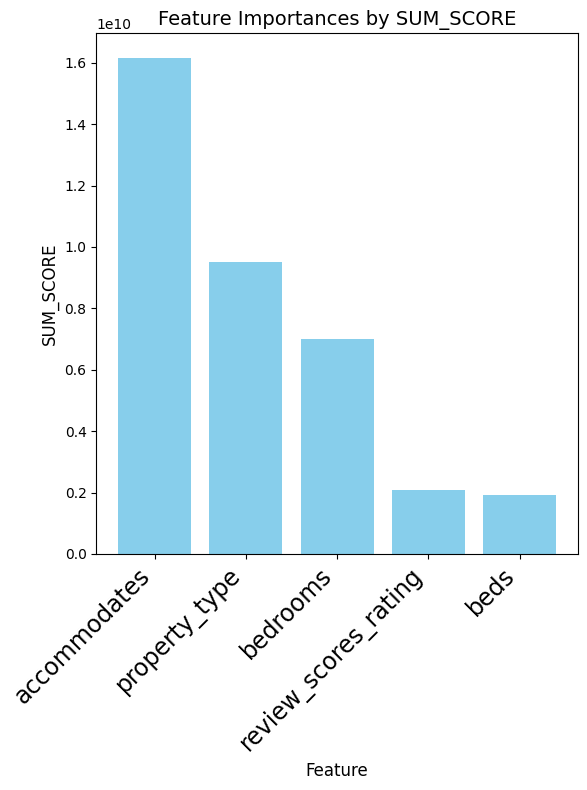

In [29]:
feature_importance = model.get_score(importance_type='total_gain')  # Replace with 'final_model' or your model variable

# Convert the importance to a DataFrame
importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
}).sort_values(by='Importance', ascending=False).head(5)

# Plot the feature importance
plt.figure(figsize=(6, 8))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xticks(rotation=45, ha='right', fontsize=17)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('SUM_SCORE', fontsize=12)
plt.title('Feature Importances by SUM_SCORE', fontsize=14)
plt.tight_layout()
plt.show()